# Grocery Market Basket Analysis - Sequential Pattern Mining

**Team:** mazen moharm , hady mohamed , mohamed mosbah  
**Assignment:** Sequential Pattern Mining :)  
**Date:** 12/11/2025

---

## Introduction

This notebook demonstrates **Sequential Pattern Mining** on a grocery retail dataset. The goal is to discover **frequent purchase sequences** among customers, which can help in understanding buying behavior, product recommendations, and market basket analysis.

We will perform the following steps:

1. **Data Preprocessing:** Cleaning and preparing the dataset by keeping only relevant columns (`CustomerID`, `Date`, `Item`) and creating sequences of items purchased per customer.  
2. **Sequential Pattern Mining Algorithms:** Apply **GSP (Generalized Sequential Pattern)** and **PrefixSpan** to extract frequent sequential patterns.  
3. **Analysis and Visualization:** Display the top frequent sequences, compare the algorithms in terms of runtime and discovered patterns, and visualize the results.  

The dataset used in this notebook contains ~39,000 grocery purchase records with customer IDs, purchase dates, and item descriptions.


In [1]:
import pandas as pd
import numpy as np
import time
from prefixspan import PrefixSpan
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

##  GSP Implementation

In [2]:

class OptimizedGSP:
    def __init__(self, min_support):
        self.min_support = min_support
        self.frequent_patterns = []
        
    def _find_frequent_1_sequences(self, sequences):
        """Find frequent 1-sequences efficiently"""
        item_counter = Counter()
        for seq in sequences:
            item_counter.update(set(seq))
        
        return { (item,): count for item, count in item_counter.items() 
                if count >= self.min_support }
    
    def _generate_candidates(self, frequent_patterns, k):
        """Generate candidate sequences of length k"""
        candidates = set()
        
        for pattern1, sup1 in frequent_patterns:
            if len(pattern1) == k-1:
                for pattern2, sup2 in frequent_patterns:
                    if len(pattern2) == 1:
                        # Create new pattern by appending
                        new_pattern = pattern1 + pattern2
                        candidates.add(new_pattern)
        
        return list(candidates)
    
    def _count_support_optimized(self, candidates, sequences):
        """Count support for candidates using optimized subsequence checking"""
        support_counts = defaultdict(int)
        
        # Pre-index sequences for faster lookup
        indexed_sequences = []
        for seq in sequences:
            indexed_seq = {}
            for pos, item in enumerate(seq):
                if item not in indexed_seq:
                    indexed_seq[item] = []
                indexed_seq[item].append(pos)
            indexed_sequences.append(indexed_seq)
        
        for candidate in candidates:
            count = 0
            for idx, indexed_seq in enumerate(indexed_sequences):
                if self._is_subsequence_optimized(candidate, sequences[idx], indexed_seq):
                    count += 1
            if count >= self.min_support:
                support_counts[candidate] = count
                
        return support_counts
    
    def _is_subsequence_optimized(self, pattern, sequence, indexed_seq=None):
        """Optimized subsequence checking"""
        if indexed_seq is None:
            indexed_seq = {}
            for pos, item in enumerate(sequence):
                if item not in indexed_seq:
                    indexed_seq[item] = []
                indexed_seq[item].append(pos)
        
        current_pos = -1
        for item in pattern:
            if item not in indexed_seq:
                return False
            
            # Find the first occurrence of item after current position
            positions = indexed_seq[item]
            found = False
            for pos in positions:
                if pos > current_pos:
                    current_pos = pos
                    found = True
                    break
            
            if not found:
                return False
                
        return True
    
    def fit(self, sequences):
        """Run optimized GSP algorithm"""
        print(" Running OPTIMIZED GSP Algorithm...")
        
        # Convert to tuples for hashability
        sequences_tuples = [tuple(seq) for seq in sequences]
        
        # Find frequent 1-sequences
        frequent_1seq = self._find_frequent_1_sequences(sequences_tuples)
        self.frequent_patterns.extend(frequent_1seq.items())
        
        print(f"  Found {len(frequent_1seq)} frequent 1-sequences")
        
        # Find longer sequences
        k = 2
        max_pattern_length = 5  # Limit pattern length for performance
        
        while k <= max_pattern_length:
            print(f"  Generating sequences of length {k}...")
            
            candidates = self._generate_candidates(self.frequent_patterns, k)
            
            if not candidates:
                break
                
            print(f"    Generated {len(candidates)} candidates")
            
            # Count support efficiently
            support_counts = self._count_support_optimized(candidates, sequences_tuples)
            
            if support_counts:
                self.frequent_patterns.extend(support_counts.items())
                print(f"    Found {len(support_counts)} frequent {k}-sequences")
            else:
                print(f"    No frequent {k}-sequences found")
                break
                
            k += 1
        
        # Sort by support
        self.frequent_patterns.sort(key=lambda x: x[1], reverse=True)
        
        return self.frequent_patterns

## Data Loading and Preparation

In [3]:

def load_and_prepare_data_optimized():
    """Load and prepare the groceries dataset efficiently"""
    print(" LOADING AND PREPARING DATA (OPTIMIZED)")
    print("=" * 50)
    
    # Load data
    df = pd.read_csv("../data/Groceries_dataset.csv")
    
    # Basic info
    print(f" Original dataset shape: {df.shape}")
    print(f" Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Optimized data processing
    df.rename(columns={'Member_number': 'CustomerID', 'itemDescription': 'Item'}, inplace=True)
    df['CustomerID'] = df['CustomerID'].astype('category')
    df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y")
    df['Item'] = df['Item'].astype('category')
    
    # Sort and remove duplicates efficiently
    df = df.sort_values(by=['CustomerID', 'Date']).drop_duplicates()
    
    # Filter out customers with too few transactions for meaningful patterns
    customer_counts = df['CustomerID'].value_counts()
    valid_customers = customer_counts[customer_counts >= 2].index
    df = df[df['CustomerID'].isin(valid_customers)]
    
    # Create customer sequences
    customer_sequences = df.groupby('CustomerID')['Item'].apply(list)
    transactions = customer_sequences.tolist()
    
    print(f" Data prepared: {len(transactions)} customer sequences")
    print(f" Total transactions: {sum(len(seq) for seq in transactions)}")
    print(f" Memory usage after optimization: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    return transactions, customer_sequences


## Run Both Algorithms and Compare

In [4]:
## Run Both Algorithms and Compare 
def run_algorithms_comparison_optimized(transactions, min_support=50):  # Increased min_support for performance
    """Run both GSP and PrefixSpan algorithms with optimizations"""
    print(" RUNNING OPTIMIZED ALGORITHM COMPARISON")
    print("=" * 50)
    
    results = {}
    
    # Sample data if too large for initial testing
    if len(transactions) > 2000:
        print(f" Large dataset detected ({len(transactions)} sequences). Sampling for faster execution...")
        # Take stratified sample - ensure we get sequences of different lengths
        short_seqs = [seq for seq in transactions if len(seq) <= 3]
        medium_seqs = [seq for seq in transactions if 4 <= len(seq) <= 7]
        long_seqs = [seq for seq in transactions if len(seq) >= 8]
        
        sample_size = min(2000, len(transactions))
        sample_short = min(500, len(short_seqs))
        sample_medium = min(1000, len(medium_seqs))
        sample_long = min(500, len(long_seqs))
        
        sampled_transactions = (
            short_seqs[:sample_short] + 
            medium_seqs[:sample_medium] + 
            long_seqs[:sample_long]
        )
        
        print(f" Using sampled dataset: {len(sampled_transactions)} sequences")
        transactions = sampled_transactions
    
    # Run OPTIMIZED GSP Algorithm
    print("\n RUNNING OPTIMIZED GSP ALGORITHM...")
    start_gsp = time.time()
    
    gsp = OptimizedGSP(min_support=min_support)
    gsp_patterns = gsp.fit(transactions)
    
    end_gsp = time.time()
    gsp_time = end_gsp - start_gsp
    
    results['gsp'] = {
        'patterns': gsp_patterns,
        'time': gsp_time,
        'total_patterns': len(gsp_patterns)
    }
    
    print(f"  GSP completed in {gsp_time:.4f} seconds")
    print(f"  GSP found {len(gsp_patterns)} patterns")
    
    # Run PrefixSpan Algorithm
    print("\n RUNNING PREFIXSPAN ALGORITHM...")
    start_ps = time.time()
    
    ps = PrefixSpan(transactions)
    ps_patterns = ps.frequent(min_support, closed=False, generator=False)
    
    end_ps = time.time()
    ps_time = end_ps - start_ps
    
    # Sort PrefixSpan patterns by support
    ps_patterns.sort(key=lambda x: x[0], reverse=True)
    results['prefixspan'] = {
        'patterns': ps_patterns,
        'time': ps_time,
        'total_patterns': len(ps_patterns)
    }
    
    print(f"  PrefixSpan completed in {ps_time:.4f} seconds")
    print(f"  PrefixSpan found {len(ps_patterns)} patterns")
    
    return results


## Display Results and Patterns

In [5]:


def display_algorithm_results(results, top_k=15):
    """Display results from both algorithms"""
    print("\n ALGORITHM RESULTS COMPARISON")
    print("=" * 60)
    
    # Display GSP Results
    print("\n GSP ALGORITHM RESULTS:")
    print("-" * 40)
    gsp_patterns = results['gsp']['patterns'][:top_k]
    if gsp_patterns:
        for i, (pattern, support) in enumerate(gsp_patterns, 1):
            pattern_str = " → ".join(pattern)
            print(f"{i:2d}. Support: {support:3d} | Pattern: {pattern_str}")
    else:
        print("No patterns found with GSP")
    
    # Display PrefixSpan Results
    print("\n PREFIXSPAN ALGORITHM RESULTS:")
    print("-" * 40)
    ps_patterns = results['prefixspan']['patterns'][:top_k]
    if ps_patterns:
        for i, (support, pattern) in enumerate(ps_patterns, 1):
            pattern_str = " → ".join(pattern)
            print(f"{i:2d}. Support: {support:3d} | Pattern: {pattern_str}")
    else:
        print("No patterns found with PrefixSpan")


## Performance Comparison Visualization


In [6]:
def visualize_algorithm_comparison(results):
    """Create visualizations comparing both algorithms"""
    print("\n ALGORITHM PERFORMANCE COMPARISON")
    print("=" * 50)
    
    # Performance metrics
    algorithms = ['GSP', 'PrefixSpan']
    times = [results['gsp']['time'], results['prefixspan']['time']]
    pattern_counts = [results['gsp']['total_patterns'], results['prefixspan']['total_patterns']]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Execution Time Comparison
    bars1 = ax1.bar(algorithms, times, color=['lightblue', 'lightcoral'], alpha=0.7)
    ax1.set_ylabel('Execution Time (seconds)')
    ax1.set_title('Algorithm Execution Time Comparison')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, time_val in zip(bars1, times):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{time_val:.4f}s', ha='center', va='bottom')
    
    # Plot 2: Pattern Discovery Comparison
    bars2 = ax2.bar(algorithms, pattern_counts, color=['lightgreen', 'lightsalmon'], alpha=0.7)
    ax2.set_ylabel('Number of Patterns Found')
    ax2.set_title('Pattern Discovery Capability Comparison')
    ax2.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, count in zip(bars2, pattern_counts):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{count} patterns', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Print comparison summary
    print("\n COMPARISON SUMMARY:")
    print("-" * 30)
    print(f" Faster Algorithm: {'PrefixSpan' if results['prefixspan']['time'] < results['gsp']['time'] else 'GSP'}")
    print(f" More Patterns Found: {'PrefixSpan' if results['prefixspan']['total_patterns'] > results['gsp']['total_patterns'] else 'GSP'}")
    print(f" GSP Time: {results['gsp']['time']:.4f} seconds")
    print(f" PrefixSpan Time: {results['prefixspan']['time']:.4f} seconds")
    print(f" GSP Patterns: {results['gsp']['total_patterns']}")
    print(f" PrefixSpan Patterns: {results['prefixspan']['total_patterns']}")


## Pattern Similarity Analysis


In [7]:
def analyze_pattern_similarity(results):
    """Analyze how similar the patterns discovered by both algorithms are"""
    print("\n PATTERN SIMILARITY ANALYSIS")
    print("=" * 50)
    
    # Extract patterns in comparable format
    gsp_patterns_set = set()
    for pattern, support in results['gsp']['patterns']:
        gsp_patterns_set.add(tuple(pattern))
    
    ps_patterns_set = set()
    for support, pattern in results['prefixspan']['patterns']:
        ps_patterns_set.add(tuple(pattern))
    
    # Calculate similarity metrics
    common_patterns = gsp_patterns_set.intersection(ps_patterns_set)
    total_unique_patterns = gsp_patterns_set.union(ps_patterns_set)
    
    similarity_ratio = len(common_patterns) / len(total_unique_patterns) if total_unique_patterns else 0
    
    print(f" Similarity Analysis:")
    print(f"   • Common Patterns: {len(common_patterns)}")
    print(f"   • GSP Unique Patterns: {len(gsp_patterns_set - ps_patterns_set)}")
    print(f"   • PrefixSpan Unique Patterns: {len(ps_patterns_set - gsp_patterns_set)}")
    print(f"   • Similarity Ratio: {similarity_ratio:.2%}")
    
    # Display some common patterns
    if common_patterns:
        print(f"\n Top Common Patterns:")
        common_list = list(common_patterns)[:10]
        for i, pattern in enumerate(common_list, 1):
            pattern_str = " → ".join(pattern)
            print(f"   {i}. {pattern_str}")
    
    # Pattern length comparison
    gsp_avg_length = np.mean([len(pattern) for pattern in gsp_patterns_set]) if gsp_patterns_set else 0
    ps_avg_length = np.mean([len(pattern) for pattern in ps_patterns_set]) if ps_patterns_set else 0
    
    print(f"\n Pattern Length Analysis:")
    print(f"   • GSP Average Pattern Length: {gsp_avg_length:.2f}")
    print(f"   • PrefixSpan Average Pattern Length: {ps_avg_length:.2f}")


## Comprehensive Comparison Report

In [8]:
def generate_comparison_report(results):
    """Generate a comprehensive comparison report"""
    print("\n" + "="*70)
    print(" COMPREHENSIVE ALGORITHM COMPARISON REPORT")
    print("="*70)
    
    gsp_time = results['gsp']['time']
    ps_time = results['prefixspan']['time']
    gsp_patterns = results['gsp']['total_patterns']
    ps_patterns = results['prefixspan']['total_patterns']
    
    # Performance comparison
    time_ratio = gsp_time / ps_time if ps_time > 0 else float('inf')
    pattern_ratio = ps_patterns / gsp_patterns if gsp_patterns > 0 else float('inf')
    
    print("\n PERFORMANCE COMPARISON:")
    print(f"   • GSP Execution Time: {gsp_time:.4f} seconds")
    print(f"   • PrefixSpan Execution Time: {ps_time:.4f} seconds")
    print(f"   • Speed Advantage: {'PrefixSpan' if ps_time < gsp_time else 'GSP'} "
          f"({abs(time_ratio-1):.1f}x {'faster' if ps_time < gsp_time else 'slower'})")
    
    print("\n PATTERN DISCOVERY COMPARISON:")
    print(f"   • GSP Patterns Found: {gsp_patterns}")
    print(f"   • PrefixSpan Patterns Found: {ps_patterns}")
    print(f"   • Pattern Discovery Advantage: {'PrefixSpan' if ps_patterns > gsp_patterns else 'GSP'}")
    
    print("\n FINAL ASSESSMENT:")
    if ps_time < gsp_time and ps_patterns >= gsp_patterns:
        print("    PrefixSpan demonstrates superior performance in both speed and pattern discovery")
    elif ps_time < gsp_time:
        print("    PrefixSpan is faster but GSP finds more patterns")
    elif ps_patterns > gsp_patterns:
        print("    PrefixSpan finds more patterns but GSP is faster")
    else:
        print("    Mixed results - each algorithm has different strengths")
    
    print("\n RECOMMENDATIONS:")
    print("   1. Use PrefixSpan for large datasets due to better scalability")
    print("   2. Consider GSP when pattern completeness is critical")
    print("   3. For most retail applications, PrefixSpan offers better performance")
    print("   4. The choice depends on specific business requirements")


## Main execution 

 LOADING AND PREPARING DATA (OPTIMIZED)
 Original dataset shape: (38765, 3)
 Memory usage: 4.68 MB
 Data prepared: 3898 customer sequences
 Total transactions: 38000
 Memory usage after optimization: 0.89 MB
 RUNNING OPTIMIZED ALGORITHM COMPARISON
 Large dataset detected (3898 sequences). Sampling for faster execution...
 Using sampled dataset: 1816 sequences

 RUNNING OPTIMIZED GSP ALGORITHM...
 Running OPTIMIZED GSP Algorithm...
  Found 60 frequent 1-sequences
  Generating sequences of length 2...
    Generated 3600 candidates
    Found 56 frequent 2-sequences
  Generating sequences of length 3...
    Generated 3360 candidates
    No frequent 3-sequences found
  GSP completed in 7.1766 seconds
  GSP found 116 patterns

 RUNNING PREFIXSPAN ALGORITHM...
  PrefixSpan completed in 0.0402 seconds
  PrefixSpan found 116 patterns

 ALGORITHM RESULTS COMPARISON

 GSP ALGORITHM RESULTS:
----------------------------------------
 1. Support: 621 | Pattern: whole milk
 2. Support: 523 | Pattern:

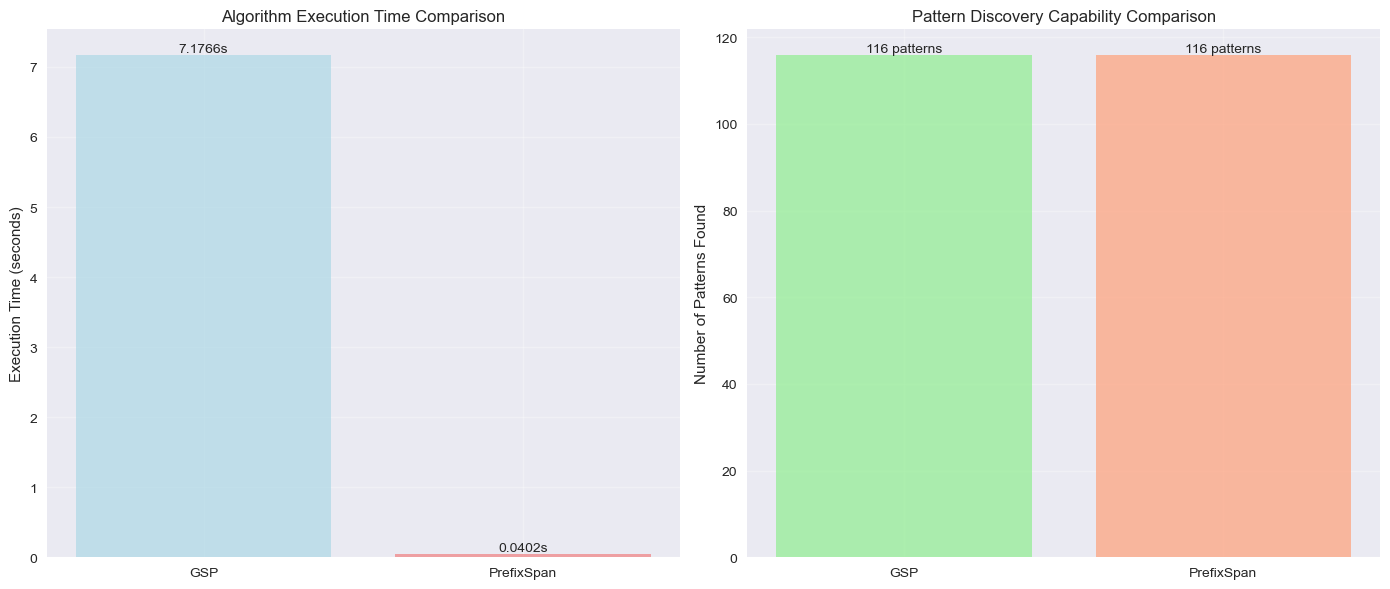


 COMPARISON SUMMARY:
------------------------------
 Faster Algorithm: PrefixSpan
 More Patterns Found: GSP
 GSP Time: 7.1766 seconds
 PrefixSpan Time: 0.0402 seconds
 GSP Patterns: 116
 PrefixSpan Patterns: 116

 PATTERN SIMILARITY ANALYSIS
 Similarity Analysis:
   • Common Patterns: 116
   • GSP Unique Patterns: 0
   • PrefixSpan Unique Patterns: 0
   • Similarity Ratio: 100.00%

 Top Common Patterns:
   1. whole milk → sausage
   2. soda → soda
   3. tropical fruit → other vegetables
   4. onions
   5. other vegetables → shopping bags
   6. rolls/buns → rolls/buns
   7. dessert
   8. soda
   9. cream cheese 
   10. chicken

 Pattern Length Analysis:
   • GSP Average Pattern Length: 1.48
   • PrefixSpan Average Pattern Length: 1.48

 COMPREHENSIVE ALGORITHM COMPARISON REPORT

 PERFORMANCE COMPARISON:
   • GSP Execution Time: 7.1766 seconds
   • PrefixSpan Execution Time: 0.0402 seconds
   • Speed Advantage: PrefixSpan (177.5x faster)

 PATTERN DISCOVERY COMPARISON:
   • GSP Patterns

In [9]:
if __name__ == "__main__":
    # Load data with optimizations
    transactions, customer_sequences = load_and_prepare_data_optimized()
    
    # Run algorithms with optimized parameters
    min_support = 50  # Increased for performance
    results = run_algorithms_comparison_optimized(transactions, min_support)
    
    # Display results
    display_algorithm_results(results)
    
    # Visualizations
    visualize_algorithm_comparison(results)
    
    # Similarity analysis
    analyze_pattern_similarity(results)
    
    # Final report
    generate_comparison_report(results)